In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, isnan, col, when,mean
spark=SparkSession.builder.appName('RegressionWithPySpark').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/11 09:42:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Explore and Defining Dataset**

In [3]:
# import dataset
df=spark.read.format('csv') \
.option('inferSchema','true') \
.option('header','true') \
.option('sep',',') \
.load('data.csv')

display(df)

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: int, NOX: double, RM: double, AGE: double, DIS: double, RAD: int, TAX: int, PTRATIO: double, B: double, LSTAT: double, MEDV: double]

In [4]:
df.columns

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MEDV']

CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over
25,000 sq.ft.

INDUS proportion of non-retail business acres per town
CHAS Charles River dummy variable (= 1 if tract bounds
river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks
by town

LSTAT % lower status of the population

MEDV Median value of owner-occupied homes in $1000's

In [5]:
print(df.count(),len(df.columns))

511 14


In [6]:
df.describe().show()

23/05/11 09:42:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+-----------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|             CRIM|                ZN|            INDUS|               CHAS|                NOX|                RM|               AGE|               DIS|              RAD|               TAX|           PTRATIO|                B|             LSTAT|             MEDV|
+-------+-----------------+------------------+-----------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|              511|               511|              511|                511|                511|               506|               511|               511|              511|  

In [7]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns] \
   ).show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|CRIM| ZN|INDUS|CHAS|NOX| RM|AGE|DIS|RAD|TAX|PTRATIO|  B|LSTAT|MEDV|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  5|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [8]:
mean_RM = df.select(mean(df['RM'])).collect()[0][0]

df = df.fillna(mean_RM, subset=['RM'])

Make our target an output label

In [9]:
df=df.withColumnRenamed('MEDV','label')
df.show()

+-------+----+-----+----+-----+-----------------+-----+------+---+---+-------+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|               RM|  AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|label|
+-------+----+-----+----+-----+-----------------+-----+------+---+---+-------+------+-----+-----+
|0.00632|18.0| 2.31|   0|0.538|            6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98| 24.0|
|0.02731| 0.0| 7.07|   0|0.469|            6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14| 21.6|
|0.02729| 0.0| 7.07|   0|0.469|            7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03| 34.7|
|0.03237| 0.0| 2.18|   0|0.458|            6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94| 33.4|
|0.06905| 0.0| 2.18|   0|0.458|            7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33| 36.2|
|0.02985| 0.0| 2.18|   0|0.458|             6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21| 28.7|
|0.08829|12.5| 7.87|   0|0.524|            6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43| 22.9|
|0.14455|12.5| 7.87|

In [10]:
from pyspark.sql.functions import corr

#shows correlation
df.select(corr('RM','label')).show()

+------------------+
|   corr(RM, label)|
+------------------+
|0.6669538165333394|
+------------------+



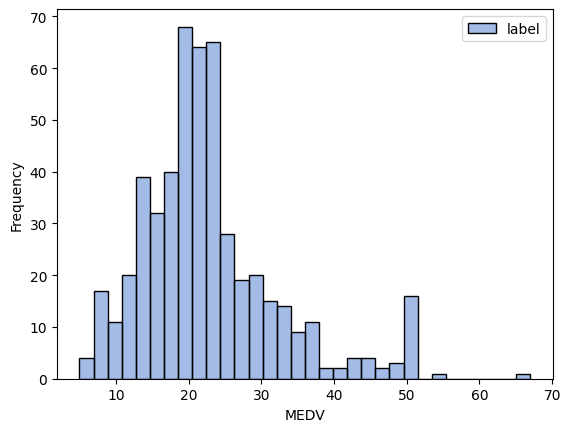

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#get label for visualziation
x = df.select('label').toPandas()
# label axeses
plt.ylabel('Frequency')
plt.xlabel('MEDV')

sns.histplot(x,palette='muted')

plt.show()

**Preparing Data with Feature Vector**

In [ ]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

# we are turning all of our features into a single vector
vec_assembler = VectorAssembler(inputCols=['CRIM','ZN','INDUS', \
                'CHAS','NOX','AGE','RM','DIS','RAD','TAX',
                'PTRATIO','B','LSTAT'],outputCol='features') 

# add it to the dataframe
features_df = vec_assembler.transform(df)  
#check if its added  
features_df.printSchema()                                                               

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = false)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
#check if its empty
features_df.select('features').show(5,False) 

+-------------------------------------------------------------------------+
|features                                                                 |
+-------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,65.2,6.575,4.09,1.0,296.0,15.3,396.9,4.98]  |
|[0.02731,0.0,7.07,0.0,0.469,78.9,6.421,4.9671,2.0,242.0,17.8,396.9,9.14] |
|[0.02729,0.0,7.07,0.0,0.469,61.1,7.185,4.9671,2.0,242.0,17.8,392.83,4.03]|
|[0.03237,0.0,2.18,0.0,0.458,45.8,6.998,6.0622,3.0,222.0,18.7,394.63,2.94]|
|[0.06905,0.0,2.18,0.0,0.458,54.2,7.147,6.0622,3.0,222.0,18.7,396.9,5.33] |
+-------------------------------------------------------------------------+
only showing top 5 rows



**Building the Linear Regression Model**

In [ ]:
#create model with features and label
model_df = features_df.select('features','label') 
model_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.02731,0.0,7.07...| 21.6|
|[0.02729,0.0,7.07...| 34.7|
|[0.03237,0.0,2.18...| 33.4|
|[0.06905,0.0,2.18...| 36.2|
+--------------------+-----+
only showing top 5 rows



In [ ]:
#split data into train and test dataframe
train_df , test_df=model_df.randomSplit([0.75,0.25])

train_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.00906,90.0,2.9...| 32.2|
|[0.01301,35.0,1.5...| 32.7|
|[0.0136,75.0,4.0,...| 18.9|
|[0.01381,80.0,0.4...| 50.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

# Initializing Linear Regression 
lin_Reg = LinearRegression(labelCol='label',regParam=.01)

# Fit our data to the model
lr_model = lin_Reg.fit(train_df)

# print slope coefficients and intercept for lin reg 
print(lr_model.coefficients)
print(lr_model.intercept)

#evaluate the model using r^2
training_predictions = lr_model.evaluate(train_df)
print(training_predictions.r2)

[-0.14120652027475708,0.04182117142375692,0.0035851640066364206,3.5125410409130526,-14.98042589842389,-0.05954367804062648,6.97876671244456,-1.5052308374998848,0.1462364172729257,-0.01098632722063642,-0.7037160470715509,0.013534749338465137,0.018674676376903718]
7.62647939272917
0.6397562618042114


In [ ]:
# evaluating model with unseen data 
test_results = lr_model.evaluate(test_df)
print(test_results.r2)
print(test_results.rootMeanSquaredError)

0.5450790719998915
6.248837202908647


**Linear Regression using Pipeline**

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

#split our data once again
train_df, test_df, = df.randomSplit([.8,.2])

#define the features
features = ['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',]

# create out_features vector from all of our features
stage_1 = VectorAssembler(inputCols=features, outputCol='out_features')
# scale our features
stage_2 = StandardScaler(inputCol='out_features',outputCol='features')
# initalize linear regression 
stage_3 = LinearRegression()
# define stages
stages=[stage_1,stage_2,stage_3]

#create our pipeline
pipeline=Pipeline(stages=stages)

In [ ]:
# fit our data
model = pipeline.fit(train_df)

# adding prediction to our test df to see actual vs prediction
pred_result = model.transform(test_df)
pred_result.show(5)

23/05/08 11:06:14 WARN Instrumentation: [29ac18d4] regParam is zero, which might cause numerical instability and overfitting.


+-------+----+-----+----+-----+-----+----+-------+---+---+-------+------+-----+-----+--------------------+--------------------+------------------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|    DIS|RAD|TAX|PTRATIO|     B|LSTAT|label|        out_features|            features|        prediction|
+-------+----+-----+----+-----+-----+----+-------+---+---+-------+------+-----+-----+--------------------+--------------------+------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|   4.09|  1|296|   15.3| 396.9| 4.98| 24.0|[0.00632,18.0,2.3...|[7.36569883299710...| 27.92312329512297|
|0.01096|55.0| 2.25|   0|0.389|6.453|31.9| 7.3073|  1|300|   15.3|394.72| 8.23| 22.0|[0.01096,55.0,2.2...|[0.00127734270901...|27.878213678840247|
|0.01439|60.0| 2.93|   0|0.401|6.604|18.8| 6.2196|  1|265|   15.6| 376.7| 4.38| 29.1|[0.01439,60.0,2.9...|[0.00167709503491...| 31.38127280650602|
|0.01709|90.0| 2.02|   0| 0.41|6.728|36.1|12.1265|  5|187|   17.0|384.46|  4.5| 30.1|[0.01709,90.0,2.0...|[0.001991768

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

#Initalizing Regression Evaluator
regeval = RegressionEvaluator(labelCol='label',predictionCol='prediction',metricName='rmse')

#evaluating our prediction
acc = regeval.evaluate(pred_result,{regeval.metricName : 'r2'})
print(acc)
rmse = regeval.evaluate(pred_result)
print(rmse)

0.6223355435411346
6.142123443414813
